# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple
from easydict import EasyDict as edict
import pickle

/home/manu/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Default lg shape= 32 32


In [2]:
#args.offset_std = 30
#args.contrast = 0.7

width = {'in': 32, 'out': 64, 'ext': 128}

n_levels = {'in': 3, 'out': 3, 'ext': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3, 'ext': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4, 'ext': width['ext'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2, 'ext': width['ext'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4, 'ext': 8}

n_azimuth = {'in': 16, 'out': 32, 'ext': 64}

n_theta = {'in': 8, 'out': 8, 'ext': 8}

n_phase = {'in': 1, 'out': 1, 'ext': 1}

do_mask = False

gauss = False






In [3]:
lg={}
for k in ['in', 'out', 'ext']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)

In [4]:
K = {}
for k in ['in', 'out', 'ext']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2759) tensor(1.)
i_sublevel, sf_0, radius 0 0.09016844005556021 32.0
i_sublevel, sf_0, radius 1 0.08268482410040674 34.896247445288246
i_sublevel, sf_0, radius 2 0.07582231801174003 38.05462768008707
i_sublevel, sf_0, radius 3 0.06952937218191597 41.49886574883231
i_sublevel, sf_0, radius 4 0.06375871541229934 45.25483399593904
i_sublevel, sf_0, radius 5 0.05846699982261449 49.350746413054104
i_sublevel, sf_0, radius 6 0.05361447523138428 53.81737057623773
i_sublevel, sf_0, radius 7 0.

In [5]:
K_inv={}
for k in ['in', 'out', 'ext']:
    K_inv[k] = get_K_inv(K[k], 
                  width=width[k], 
                  n_sublevel = n_sublevel[k], 
                  n_azimuth = n_azimuth[k], 
                  n_theta = n_theta[k], 
                  n_phase = n_phase[k])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])
Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])
Filter tensor shape= torch.Size([128, 128, 8, 64, 8, 1])
Reshaped filter tensor= torch.Size([16384, 4096])
Tensor shape= torch.Size([4096, 16384])


# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [6]:
args = init(filename='2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [7]:
class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out', 'ext']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   

### LogGaborTransform

In [8]:
class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out', 'ext']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs

In [9]:
class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out', 'ext']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs

In [10]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):

        if self.verbose:
            print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels-1, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [11]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        log_gabor_coeffs = torch.cat((log_gabor_coeffs,torch.zeros_like(log_gabor_coeffs[:,:1,...])), dim=1) 
        img_crop=inverse_gabor(log_gabor_coeffs.detach(), self.K_inv, self.verbose)
        if self.verbose:
            print('img_crop.shape:', img_crop.shape)

        return img_crop

In [12]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb',
                 N_X = 256,
                 N_Y = 256):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
        self.N_X = N_X
        self.N_Y = N_Y

    def __call__(self, img_crop):
        #print('img_crop.shape:', img_crop.shape)
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = self.N_X,
                                       N_Y = self.N_Y,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels) #,
                                       #color_mode=self.color_mode)
        return full_img_rec

### Inverse transformations (for display only)

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [13]:
#args.offset_max = 40 #like in the paper

In [14]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [15]:
image_size = 256

vgg_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm, 
        ])

polo_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            #transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

transform_big =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [16]:
width,base_levels, color, n_levels

({'in': 32, 'out': 64, 'ext': 128}, 2, True, {'in': 3, 'out': 3, 'ext': 3})

In [17]:
#image_path = "../data/animal/"
image_path = "/media/manu/Seagate Expansion Drive/Data/animal/"

vgg_image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=vgg_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test', 
                            transform=vgg_transform
                        )
                }

In [18]:
polo_image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=polo_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test', 
                            transform=polo_transform
                        )
                }

In [19]:
dataset_size = {'train' : len(vgg_image_dataset['train']),
                'test' : len(vgg_image_dataset['test'])}

dataset_size['train'], dataset_size['test']

(20000, 4000)

In [20]:
args.batch_size = 50
num_workers = 1

vgg_dataloader = { 'train' : torch.utils.data.DataLoader(
                            vgg_image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            vgg_image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [21]:
polo_dataloader = { 'train' : torch.utils.data.DataLoader(
                            polo_image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            polo_image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [22]:
data, label = next(iter(polo_dataloader['train']))

In [23]:
data[0]

tensor([[[[0.0314, 0.0627, 0.0824,  ..., 0.0235, 0.0118, 0.0039],
          [0.0353, 0.0667, 0.0824,  ..., 0.0039, 0.0000, 0.0000],
          [0.0314, 0.0627, 0.0824,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.2392, 0.2471, 0.2667,  ..., 0.0275, 0.0275, 0.0275],
          [0.2549, 0.2745, 0.2941,  ..., 0.0314, 0.0314, 0.0275],
          [0.2392, 0.2706, 0.3020,  ..., 0.0196, 0.0275, 0.0275]],

         [[0.0235, 0.0353, 0.0431,  ..., 0.0275, 0.0157, 0.0078],
          [0.0235, 0.0353, 0.0431,  ..., 0.0078, 0.0039, 0.0039],
          [0.0157, 0.0353, 0.0471,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.1922, 0.2196, 0.2471,  ..., 0.0039, 0.0039, 0.0039],
          [0.2196, 0.2588, 0.2784,  ..., 0.0039, 0.0039, 0.0039],
          [0.2196, 0.2627, 0.2745,  ..., 0.0118, 0.0039, 0.0039]],

         [[0.0392, 0.0431, 0.0275,  ..., 0.0471, 0.0314, 0.0235],
          [0.0353, 0.0431, 0.0314,  ..., 0.0118, 0.0118, 0.0157],
          [0.0275, 0.0392, 0.0314,  ..., 0

In [24]:
data_original = data[0]
data_polo = data[1]
data_original.shape, data_polo['in'].shape, data_polo['out'].shape, data_polo['ext'].shape

(torch.Size([50, 3, 256, 256]),
 torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]),
 torch.Size([50, 24, 16, 64]))

In [25]:
img_size = np.prod(data_original.shape)//args.batch_size
print('original image size:', img_size)

polo_size = {}
for k in ('in', 'out', 'ext'):
    polo_size[k] = np.prod(data_polo[k].shape) //args.batch_size
    print(k, ':', polo_size[k])
total_polo_size = polo_size['in'] + polo_size['out'] + polo_size['ext']

print('total polo size:', total_polo_size) 
print(f'compression rate : {100 * (1 - total_polo_size/img_size):.2f} %')

original image size: 196608
in : 1536
out : 6144
ext : 24576
total polo size: 32256
compression rate : 83.59 %


In [26]:
n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase

({'in': 3, 'out': 3, 'ext': 3},
 {'in': 3, 'out': 3, 'ext': 3},
 {'in': 2, 'out': 4, 'ext': 8},
 {'in': 16, 'out': 32, 'ext': 64},
 {'in': 8, 'out': 8, 'ext': 8},
 {'in': 1, 'out': 1, 'ext': 1})

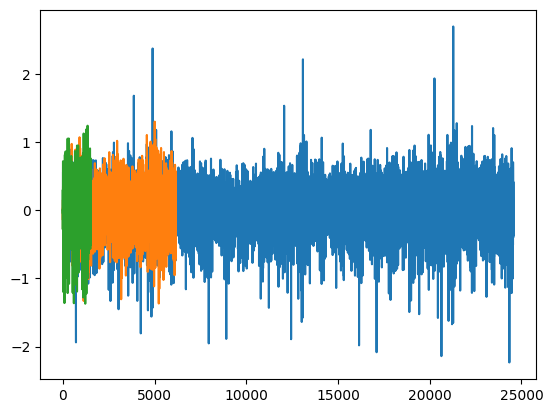

In [27]:
plt.plot(data_polo['ext'][3,...].detach().numpy().flatten())
plt.plot(data_polo['out'][3,...].detach().numpy().flatten())
plt.plot(data_polo['in'][3,...].detach().numpy().flatten())



### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [28]:
inverse_transform = {}
verbose = True
for k in ['in', 'out', 'ext']:
    N_X = N_Y = width[k] * 2**(n_levels[k]-1)
    print(N_X)
    inverse_transform[k] = transforms.Compose([
        LogGaborInvReshape(n_levels[k], n_color[k], n_eccentricity[k], n_azimuth[k], n_theta[k], n_phase[k], color=color, verbose=verbose),        
        LogGaborInvTransform(K_inv=K_inv[k], color=color, verbose=verbose),
        InvCroppedPyramid(base_levels, n_levels=n_levels[k], verbose=verbose, N_X=N_X, N_Y=N_Y),
    ])

128
256
512


In [29]:
def img_denorm(img, mean, std):
    #for ImageNet the mean and std are:
    #mean = np.asarray([ 0.485, 0.456, 0.406 ])
    #std = np.asarray([ 0.229, 0.224, 0.225 ])

    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    res = img.squeeze(0)
    res = denormalize(res)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return(res)

- The Log-Polar compressed format

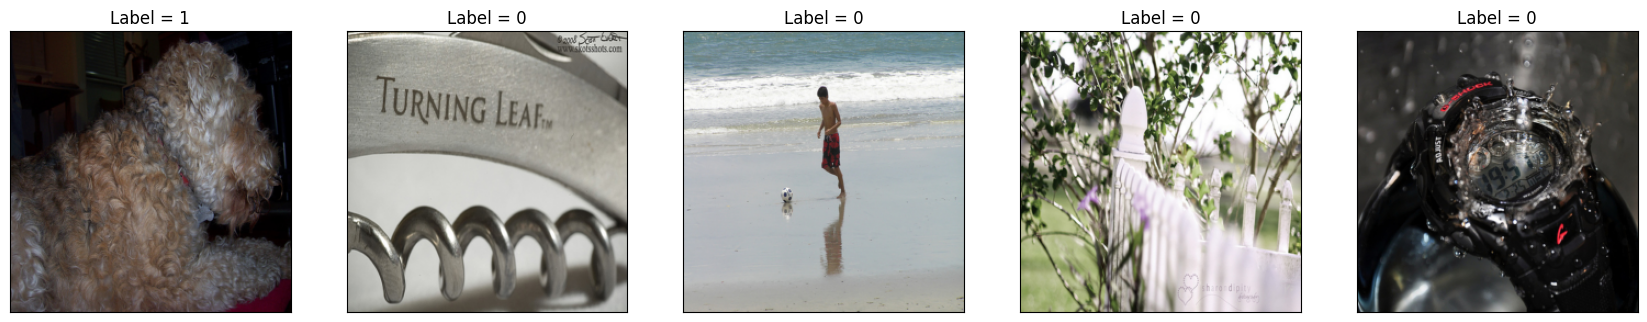

In [30]:

#for i in range(len(data_original)):
#    data_original[i] = img_denorm(data_original[i], v_mean, v_std)
original = view_data(data_original, label, 5)

In [31]:
inverse_transform['ext']

Compose(
)

In [32]:
b = {'in':32,'out':64, 'ext': 128}
img_sum = torch.zeros(batch_size, 3, 256, 256)
for k in ['in', 'out', 'ext']:
    data = data_polo[k] #
    #data = torch.cat((data_polo[k],torch.zeros_like(data_polo[k][:,:1,...])), dim=1) 
    full_img_rec = inverse_transform[k](data)
    img_aff = full_img_rec[:,:,b[k]:-b[k],b[k]:-b[k]]    
    if k == 'ext':
        img_sum += img_aff
    else:
        img_sum[:,:,128-b[k]:128+b[k],128-b[k]:128+b[k]]  += img_aff

    for i in range(len(data_original)):
        img_sum[i] = img_denorm(img_sum[i]-0.5
                                , v_mean, v_std)
    _ = view_data(img_sum, label, 5)
_ = view_data(data_original, label, 5)

NameError: name 'batch_size' is not defined

- The original format

In [ ]:
data_polo['in'].shape, data_polo['out'].shape, data_polo['ext'].shape

(torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]),
 torch.Size([50, 24, 16, 64]))

# Creating an Attention Transformer model with log-polar entry (POLO-STN)

In [ ]:
transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [ ]:
def negentropy_loss(model, z):
    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0)
    p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    return model.LAMBDA * p.log_prob(z).sum()

In [ ]:
def kl_divergence(model, z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), args.radius * torch.ones_like(std))

    # 2. get the probabilities from the equation
    #log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0)
    q = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    log_qzx = q.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = model.LAMBDA * kl.sum()
    return kl

In [37]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, do_what=False, deterministic=False, LAMBDA=.1):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.do_what = do_what
        self.deterministic = deterministic
        
        self.LAMBDA = LAMBDA

        ##  The what pathway
        self.wloc0 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              50, 3, padding=1)
        self.wloc1a = nn.Conv2d(50, 100, 3, padding=1)
        self.wloc1b = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              50, 3, padding=1)
        self.wloc2a = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2b = nn.Conv2d(50, 100, 3, padding=1)
        self.wloc2c = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               50, 3, padding=1)
        self.wloc3 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100+200), 
                              1000)
        self.wloc4 = nn.Linear(1000, 2)

        #self.wloc4.weight.data.zero_()
        #self.wloc4.bias.data.zero_()

                
        ##  The where pathway        
        self.loc0 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              50, 5, padding=2, stride=2)
        self.loc1a = nn.Conv2d(50, 100, 5, padding=2, stride=2)
        self.loc1b = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              50, 5, padding=2, stride=2)
        self.loc2a = nn.Conv2d(100, 200, 5, padding=2, stride=2)
        self.loc2b = nn.Conv2d(50, 100, 5, padding=2,stride=2)
        self.loc2c = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               50, 5, padding=2,stride=2)
        self.loc3 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100+200), 
                              1000)
        self.mu = nn.Linear(1000, 2, bias=False)
        self.logvar = nn.Linear(1000, 2, bias=False)
        
        

        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            xs_part = {}
            #for k in ['in', 'out']:
            #    print(x_polo[k].shape)
            #    xs_part[k] = x_polo[k].permute(0,2,5,6,1,3,4)
            #    xs_part[k] = xs_part[k].view(-1, n_color[k] * n_theta[k] * n_phase[k], 
            #                                 (n_levels[k]-1) * n_eccentricity[k], 
            #                                 n_azimuth[k])

            #print(x_polo['out'].shape)

            if True: #with torch.no_grad():

                xs = F.relu(self.loc0(x_polo['ext']))

                xsa = F.relu(self.loc1a(xs))
                xsb = F.relu(self.loc1b(x_polo['out']))

                xsa = F.relu(self.loc2a(xsa))
                xsb = F.relu(self.loc2b(xsb))
                xsc = F.relu(self.loc2c(x_polo['in']))
                
                xs = torch.cat((xsa, xsb, xsc), dim=1)
            xs = F.relu(self.loc3(xs.view(-1, 
                                          (50+100+200) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
            #theta = F.sigmoid(self.loc4(xs)) - 0.5
            #theta = self.loc4(xs)
            mu = self.mu(xs)
            if self.deterministic:
                sigma = args.radius * torch.ones_like(mu)  
                self.q = torch.distributions.Normal(mu, sigma)  
                z = mu
            else:
                logvar = self.logvar(xs) + 5
                sigma = torch.exp(-logvar / 2)
                self.q = torch.distributions.Normal(mu, sigma)      
                z = self.q.rsample()
            
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            mu = torch.tensor([0, 0],dtype=torch.double)
            mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            sigma = torch.tensor([1, 1],dtype=torch.double)
            sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)    
            
            if self.do_what:
                self.q = torch.distributions.Normal(mu, 0.3*sigma)
                z = self.q.rsample()
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
                grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
                grid = F.affine_grid(theta, grid_size)
                x = F.grid_sample(x, grid)
            else:
                z = torch.tensor([0, 0],dtype=torch.float)
                z = z.unsqueeze(0).repeat(x.size()[0], 1)

                theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                    dtype=torch.float),
                                        requires_grad=False)
                theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            
              
        return x, theta, z, mu, sigma

    def forward(self, x, x_polo):
        # transform the input
        x, theta, z, mu, sigma = self.stn(x, x_polo)
        
        if self.do_stn:
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out']),
                       'ext': torch.zeros_like(x_polo['ext'])}
            for i in range(args.batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
                w_x_polo['ext'][i,...] = w['ext']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass

        ya = F.relu(self.wloc0(w_x_polo['ext']))
        ya = nn.MaxPool2d(2)(ya)     
        ya = F.relu(self.wloc1a(ya))
        ya = nn.MaxPool2d(2)(ya)
        ya = F.relu(self.wloc2a(ya))
        ya = nn.MaxPool2d(2)(ya)


        yb = F.relu(self.wloc1b(w_x_polo['out']))
        yb = nn.MaxPool2d(2)(yb)        
        yb = F.relu(self.wloc2b(yb))
        yb = nn.MaxPool2d(2)(yb)
        
        yc = F.relu(self.wloc2c(w_x_polo['in']))
        yc = nn.MaxPool2d(2)(yc)
        
        #print(xsb.shape)

        y = torch.cat((ya, yb, yc), dim=1)
        y = F.relu(self.wloc3(y.view(-1, (50+100+200) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
        y = self.wloc4(y)
        return y, theta, z, mu, sigma

In [38]:
LAMBDA = 1e-4
deterministic = True
lr = 1e-4
args.batch_size = 50
args.radius = 0.1

In [33]:
path = 'out/'
f_prefix = "230222_polo_stn_dual_WHAT_0.5"
#f_prefix = "230222_polo_stn_dual_lambda_0.0001_0.2"


In [34]:
with open(f"{path}{f_prefix}.pkl", "rb") as f:
    data = pickle.load(f)
data=edict(data)

Text(0.5, 1.0, 'Entropy')

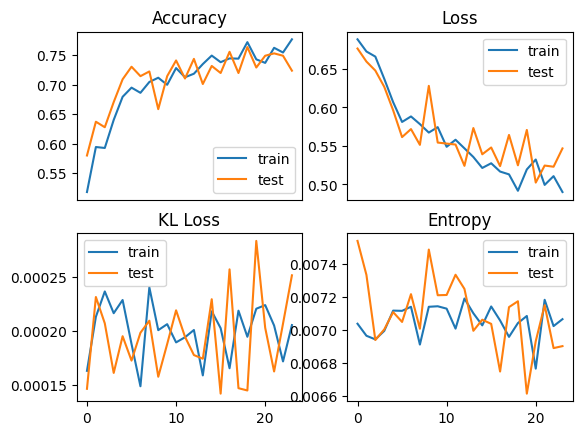

In [35]:
plt.subplot(2,2,1)
plt.plot(data.train_acc, label='train')
plt.plot(data.test_acc, label='test')
plt.legend()
plt.xticks([])
plt.title('Accuracy')
plt.subplot(2,2,2)
plt.plot(data.train_loss, label='train')
plt.plot(data.test_loss, label='test')
plt.legend()
plt.title('Loss')
plt.xticks([])
plt.subplot(2,2,3)
plt.plot(data.train_kl_loss, label='train')
plt.plot(data.test_kl_loss, label='test')
plt.legend()
plt.title('KL Loss')
plt.subplot(2,2,4)
plt.plot(data.train_entropy, label='train')
plt.plot(data.test_entropy, label='test')
plt.legend()
plt.title('Entropy')

Text(0.5, 1.0, 'Entropy')

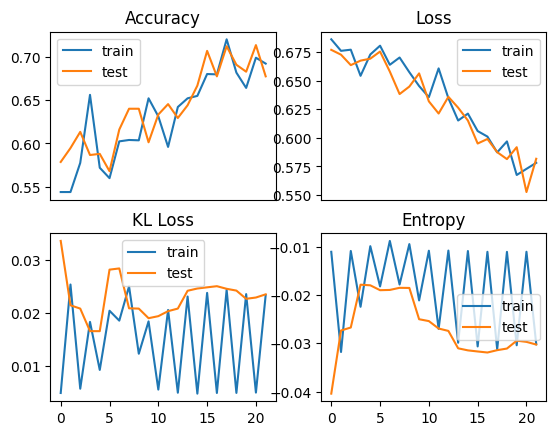

In [ ]:
plt.subplot(2,2,1)
plt.plot(data.train_acc, label='train')
plt.plot(data.test_acc, label='test')
plt.legend()
plt.xticks([])
plt.title('Accuracy')
plt.subplot(2,2,2)
plt.plot(data.train_loss, label='train')
plt.plot(data.test_loss, label='test')
plt.legend()
plt.title('Loss')
plt.xticks([])
plt.subplot(2,2,3)
plt.plot(data.train_kl_loss, label='train')
plt.plot(data.test_kl_loss, label='test')
plt.legend()
plt.title('KL Loss')
plt.subplot(2,2,4)
plt.plot(data.train_entropy, label='train')
plt.plot(data.test_entropy, label='test')
plt.legend()
plt.title('Entropy')

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet(LAMBDA=LAMBDA, deterministic=deterministic).to(device)



In [40]:
data, label = next(iter(polo_dataloader['test']))

In [41]:
model = torch.load(f"{path}{f_prefix}.pt", map_location=device)

In [42]:
output = model.stn(data[0], data[1])

tensor([0.2509, 0.2130])


In [44]:
num=1
with torch.no_grad():
    cat = model(data[0], data[1])
cat = torch.argmax(F.softmax(cat[0]),1)

tensor([-0.1604,  0.2240])


In [45]:
cat

tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0])

[0.25093424 0.21296111]
[ 0.0468805  -0.34179321]
[-0.37343066  0.25732939]
[ 0.42111032 -0.06224087]
[ 0.09589158 -0.33592968]
[1.04456946e-01 5.19593701e-05]
[ 0.25872428 -0.26869096]
[-0.28592512  0.10152442]
[ 0.05739272 -0.08740629]
[-0.03164189 -0.21220407]
[ 0.05686445 -0.18710104]
[-0.51833991  0.48139037]
[ 0.28929921 -0.19404114]
[-0.28017839 -0.54236216]
[ 0.32906069 -0.01593274]
[-0.16713849  0.03713909]
[-0.09305456 -0.48747201]
[0.33781895 0.03153421]
[-0.40709896 -0.29696346]
[ 0.11979089 -0.11615332]
[0.08530467 0.37785225]
[-0.48676467 -0.46278308]
[-0.14280142 -0.48764854]
[ 0.05809061 -0.10446162]
[ 0.13565887 -0.05627637]


/tmp/ipykernel_4636/3119125566.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,10))


[-0.08863876 -0.06783497]
[0.24734679 0.3470416 ]
[-0.05286665  0.07528818]
[-0.14879516 -0.09231624]
[-0.35690914  0.12147432]
[ 0.20717657 -0.32203651]
[-0.10126448 -0.27900693]
[ 0.03740229 -0.08855176]
[ 0.18184151 -0.46639257]
[-0.59336847  0.04231277]
[0.35564408 0.42826275]
[-0.297619   -0.15378233]
[0.34949255 0.46780586]
[-0.01548685  0.29206464]
[-0.58487309  0.24387552]
[-0.35856618  0.25767293]
[0.05148958 0.48813062]
[0.42490178 0.15162068]
[ 0.10422564 -0.2201454 ]
[-0.62832776  0.3337718 ]
[-0.10181352  0.0623087 ]
[-0.41591316 -0.29560063]
[-0.39327072 -0.46173185]
[ 0.50717174 -0.30467762]
[-0.06796397  0.16025243]


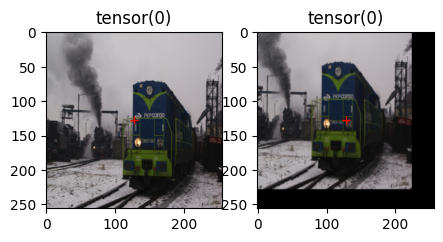

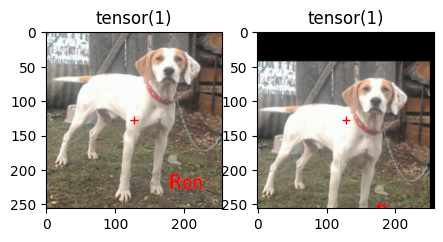

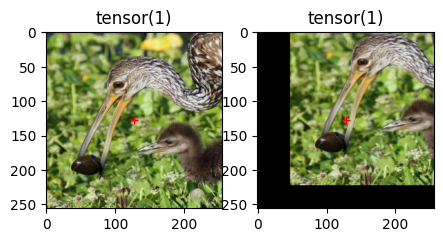

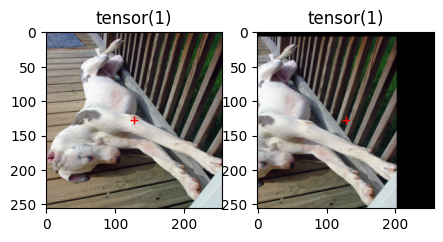

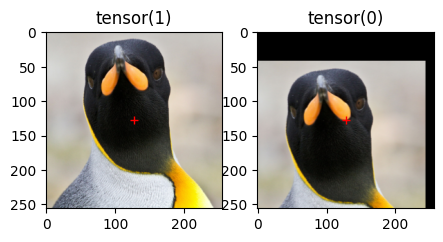

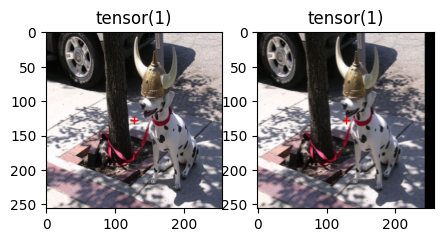

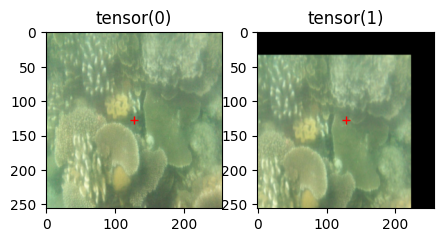

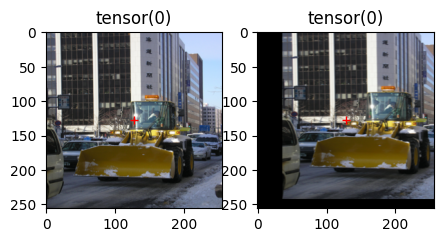

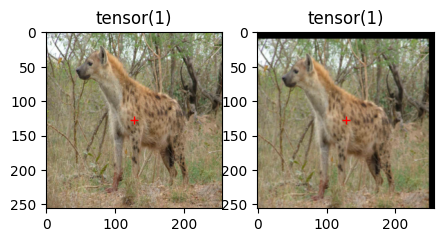

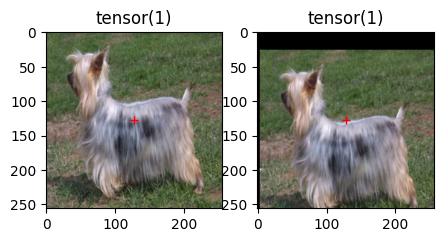

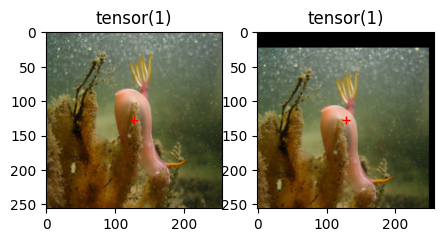

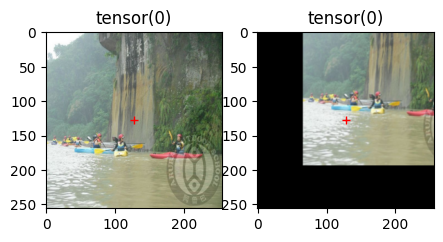

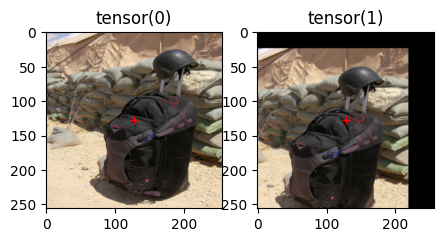

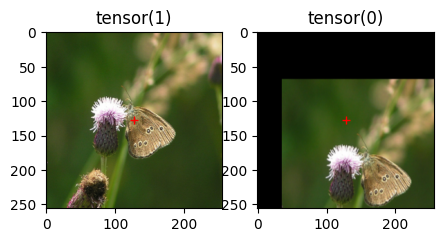

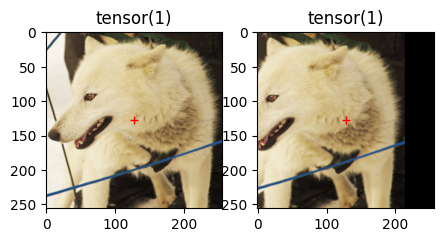

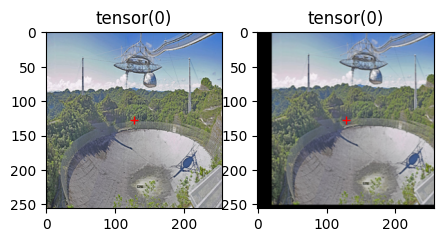

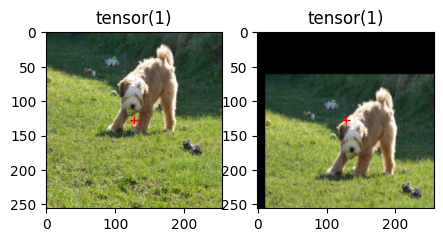

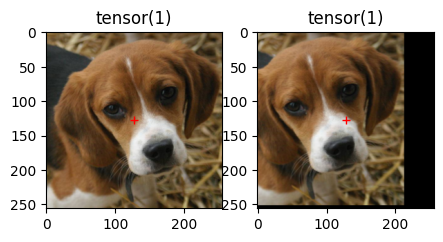

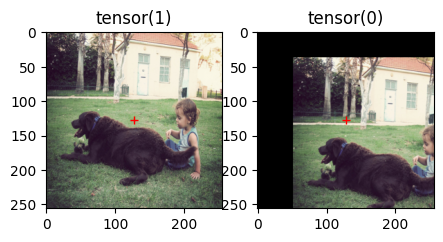

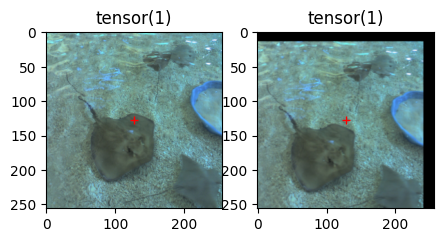

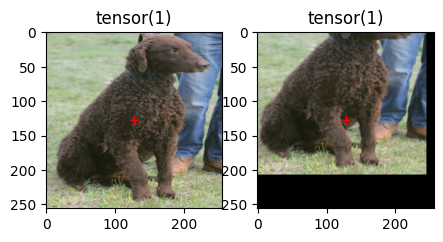

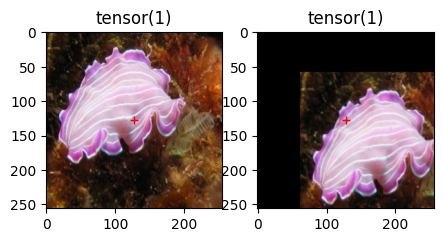

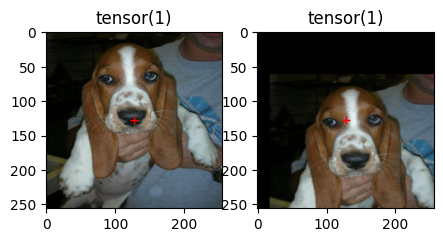

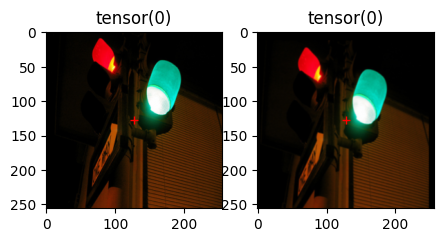

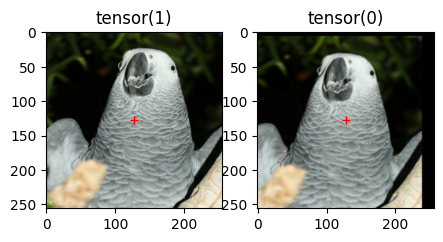

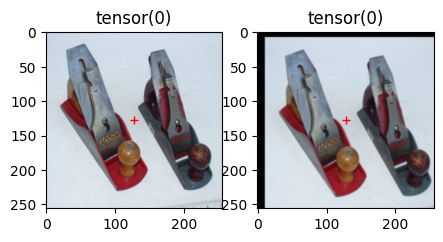

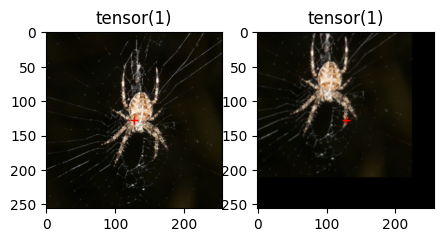

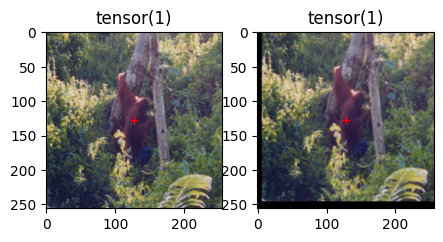

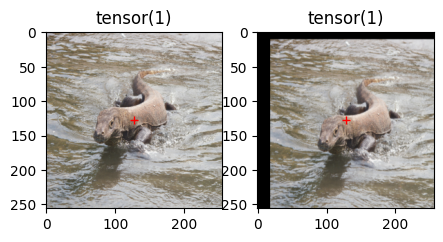

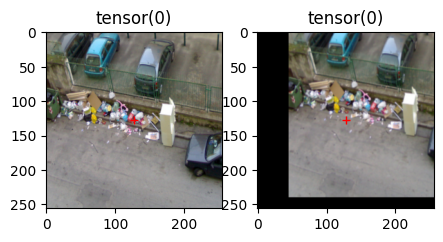

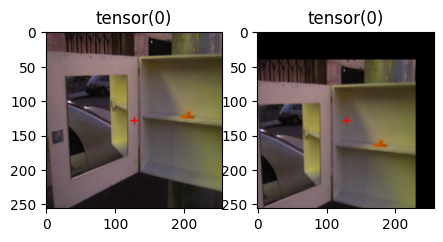

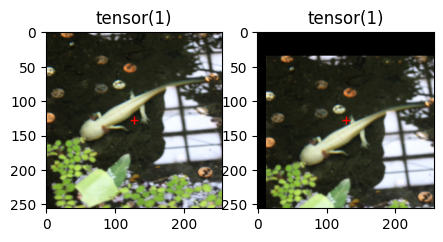

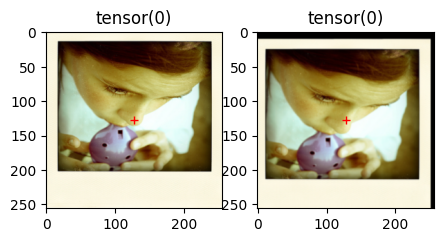

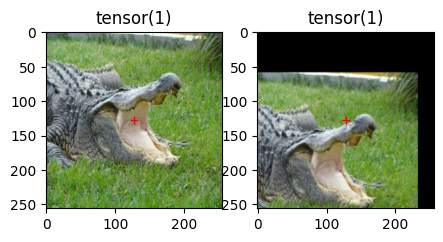

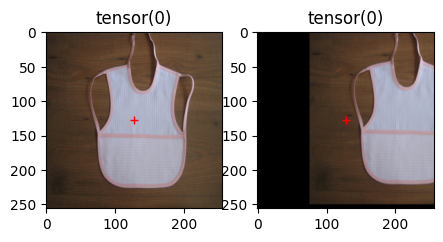

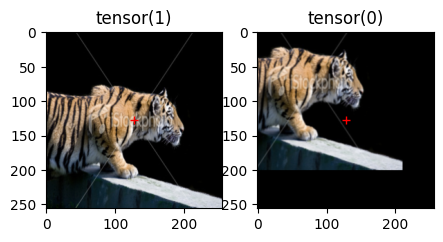

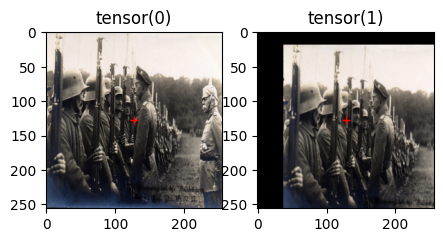

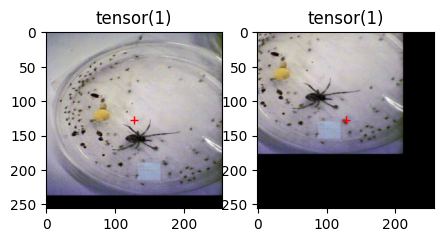

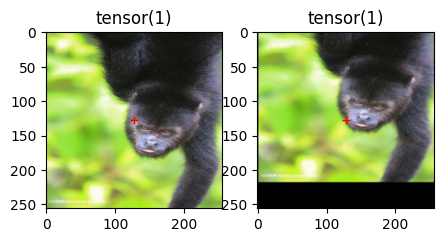

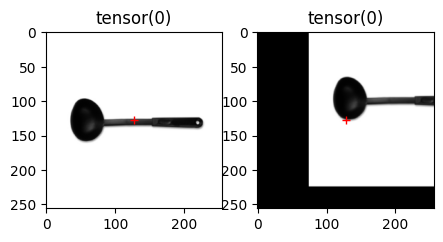

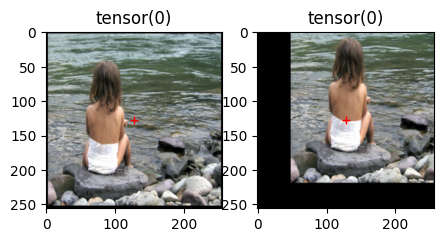

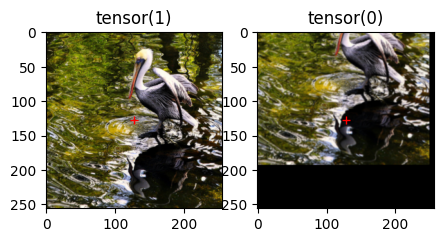

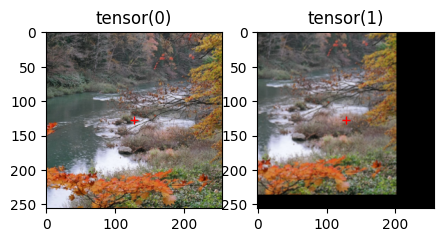

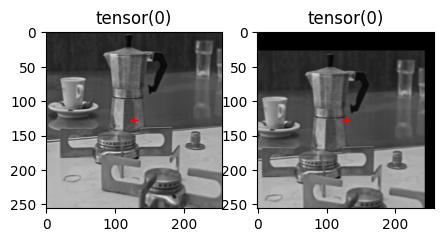

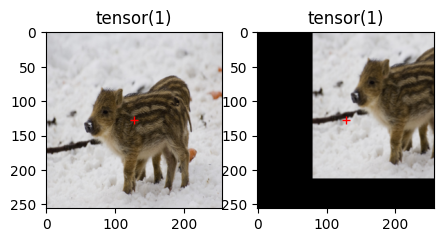

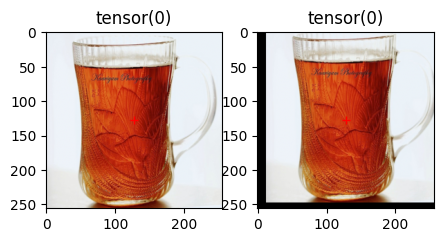

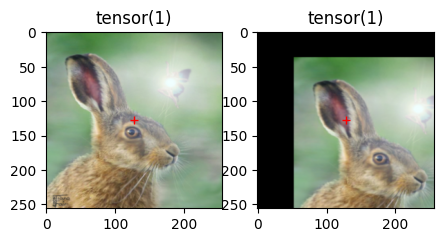

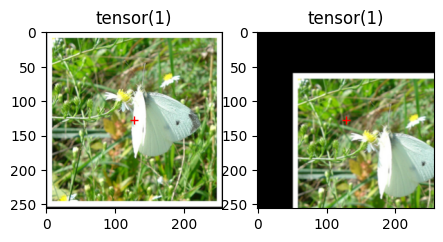

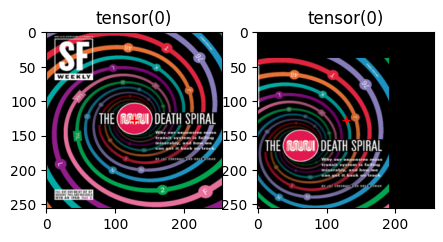

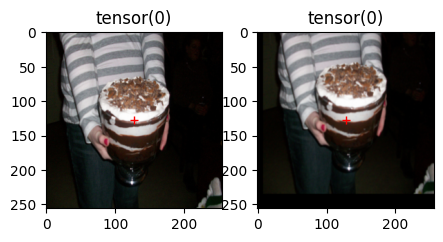

In [46]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
for num in range(50):
        plt.figure(figsize=(5,10))
        plt.subplot(1,2,1)
        img = data[0][num:num+1,...]   
        theta = output[1][num:num+1,...]
        #theta[0,:,2] = torch.FloatTensor((0,.5))
        print(theta[0,:,2].detach().numpy())
        grid_size = torch.Size([1, 3, 256, 256])
        grid = F.affine_grid(theta, grid_size)
        img_grid = F.grid_sample(img, grid)
        plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(label[num])
        plt.subplot(1,2,2)
        plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(cat[num])

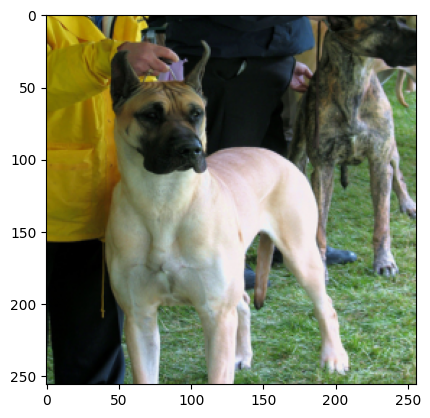

In [ ]:
plt.imshow(data[0][1,:].permute(1,2,0).detach().numpy())

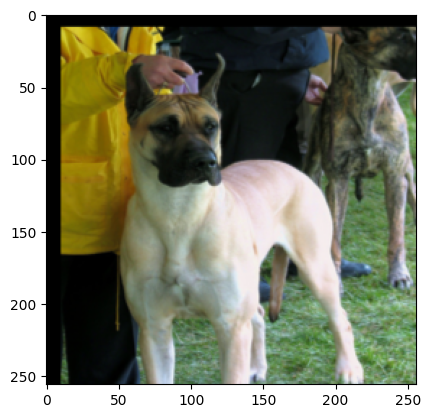

In [ ]:
plt.imshow(output[0][1,:].permute(1,2,0).detach().numpy())

In [ ]:
output[1][1][:,2].detach().numpy()

array([-0.08021453, -0.06861009])